In [133]:
import os
import random
import cv2
import numpy as np

from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [134]:
def rotacionar_imagem(img, angulo):
    height = img.shape[0]  # número de linhas
    width = img.shape[1]  # número de colunas

    centroY = height / 2
    centroX = width / 2

    matrizRotacao = cv2.getRotationMatrix2D((centroX, centroY), angulo, 1.0)

    img_rot = cv2.warpAffine(img, matrizRotacao, (width, height))

    return img_rot


In [135]:
def ransac(img1, img2, kp1, kp2, good_matches):
    # Deve conter no caso MIN_MATCH_COUNT para considerar que encontrou a imagem
    inliers = 0
    outliers = 0
    img_difference = 0
    MIN_MATCH_COUNT = 20
    if len(good_matches) > MIN_MATCH_COUNT:
        # Se verdade, desenhar os inliers
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Matriz homográfica com RANSAC
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()  # inliers


        # Calcula INLIERS e OUTLIERS
        # mask: é um vetor que possui 0 e 1. Sendo que 1 é inlier e 0 outliers
        for i, m in enumerate(mask):
            if m:
                inliers += 1
            else:
                outliers += 1

        # Posiciona uma imagem em relação a outra
        h, w = img1.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        dst = cv2.perspectiveTransform(pts, M)
        img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

        # --- TRANSFORMAÇÃO: visando encaixar a imagem 2 na imagem 1
        # Invertendo a transformação para subtrair da imagem original
        M_inv = np.linalg.inv(M)  # calcula matriz inversa
        img2_transformed = cv2.warpPerspective(img2, M_inv, (img1.shape[1], img1.shape[0]))
        # Subtraindo a imagem transformada da imagem original
        img_diff = cv2.absdiff(img1, img2_transformed)
        # Exibi a imagem obtida por meio da subtração
        img_difference = np.mean(img_diff)
    else:
        matchesMask = None

    return inliers, outliers, img_diff, img_difference, matchesMask

In [136]:
def fast_brief(query_img, train_img):
    inicio = datetime.now()

    img1 = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)

    fast = cv2.FastFeatureDetector_create()

    kp1 = fast.detect(img1, None)
    kp2 = fast.detect(img2, None)

    # Extrai os descritores usando o BRIEF
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    kp1, des1 = brief.compute(img1, kp1)
    kp2, des2 = brief.compute(img2, kp2)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Definir um limiar de distância para filtrar correspondências ruins
    threshold_distance = 20

    # Filtrar correspondências com base no limiar de distância
    good_matches = []
    for match in matches:
        if match.distance < threshold_distance:
            good_matches.append(match)

    fim = datetime.now()

    tempo_gasto = fim - inicio

    inliers, outliers, img_diferenca, diferenca, matchesMask = ransac(img1, img2, kp1, kp2, good_matches)

    # desenha os inliers
    draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask,  # draw only inliers
                       flags=2)

    img_correspondencia = cv2.drawMatches(img1, kp1,
                           img2, kp2, good_matches, None, **draw_params)

    return inliers, outliers, diferenca, tempo_gasto, img_correspondencia, img_diferenca


In [137]:
def sift_sift(query_img, train_img):
    inicio = datetime.now()
    # Converte para Cinza para trabalhar com um canal apenas
    img1 = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)

    # Inicializa o SIFT
    sift = cv2.SIFT_create()

    # Extrai os pontos chaves e descritores
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)


    # --> Faz Correspondência
    # Correspondência
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Armazena todas as boas correspondências de acordo com o teste de proporção de Lowe's
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    fim = datetime.now()

    tempo_gasto = fim - inicio

    inliers, outliers, img_diferenca, diferenca, matchesMask = ransac(img1, img2, kp1, kp2, good_matches)

    # desenha os inliers
    draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask,  # draw only inliers
                       flags=2)

    img_correspondencia = cv2.drawMatches(img1, kp1,
                           img2, kp2, good_matches, None, **draw_params)

    return inliers, outliers, diferenca, tempo_gasto, img_correspondencia, img_diferenca

In [138]:
def equaliza_cor(sat, uav):
    # Converter ambas as imagens para o espaço de cor Lab
    sat = cv2.cvtColor(sat, cv2.COLOR_BGR2LAB)
    uav = cv2.cvtColor(uav, cv2.COLOR_BGR2LAB)

    # Calcular a média e o desvio padrão dos canais L, a e b da imagem SAT
    media_pixels_sat, desvio_padrao_sat = cv2.meanStdDev(sat)
    # achatada em um array 1D, que pode ser mais facilmente manipulado
    media_pixels_sat = media_pixels_sat.ravel()
    desvio_padrao_sat = desvio_padrao_sat.ravel()

    # Calcular a média e o desvio padrão dos canais L, a e b da imagem SAT
    media_pixels_uav, desvio_padrao_uav = cv2.meanStdDev(sat)
    # achatada em um array 1D, que pode ser mais facilmente manipulado
    media_pixels_uav = media_pixels_uav.ravel()
    desvio_padrao_uav = desvio_padrao_uav.ravel()

    # Normalizar os canais da imagem UAV pela média e desvio padrão da imagem SAT
    uav[:, :, 0] = np.clip((desvio_padrao_sat[0] / desvio_padrao_uav[0]) * (uav[:, :, 0] - media_pixels_uav[0])
                           + media_pixels_sat[0], 0, 255)
    uav[:, :, 1] = np.clip((desvio_padrao_sat[1] / desvio_padrao_uav[1]) * (uav[:, :, 1] - media_pixels_uav[1])
                   + media_pixels_sat[1], 0, 255)
    uav[:, :, 2] = np.clip((desvio_padrao_sat[2] / desvio_padrao_uav[2]) * (uav[:, :, 2] - media_pixels_uav[2])
                   + media_pixels_sat[2], 0, 255)

    # Converter de volta para o espaço de cor BGR
    result = cv2.cvtColor(uav, cv2.COLOR_LAB2BGR)

    cv2.imwrite('../../template-matching/app-correspondencia-imagem/public/images/equalize_color_img1.jpg', result)

    return result

In [139]:
img_anterior = cv2.imread('./database/alvares_machado/03-20/alvares_machado_0.jpg')
img_atual = cv2.imread('./database/alvares_machado/06-22/alvares_machado_0.jpg')

# img_anterior = cv2.imread('./database/curitiba/04-20/curitiba_2.jpg')
# img_atual = cv2.imread('./database/curitiba/05-21/curitiba_2.jpg')

In [140]:
img_anterior = equaliza_cor(img_atual, img_anterior)
# img_atual = rotacionar_imagem(img_atual, 45)

In [141]:
# ---> SIFT-SIFT
inliers, outliers, diferenca, tempo, img_correspondencia, img_diferenca = sift_sift(img_anterior, img_atual)
# ---> FAST-BRIEF
# inliers, outliers, diferenca, tempo, img_correspondencia, img_diferenca = fast_brief(img_anterior, img_atual)

In [142]:
print(f"Inliers = {inliers}\nOutliers = {outliers}")

Inliers = 12
Outliers = 34


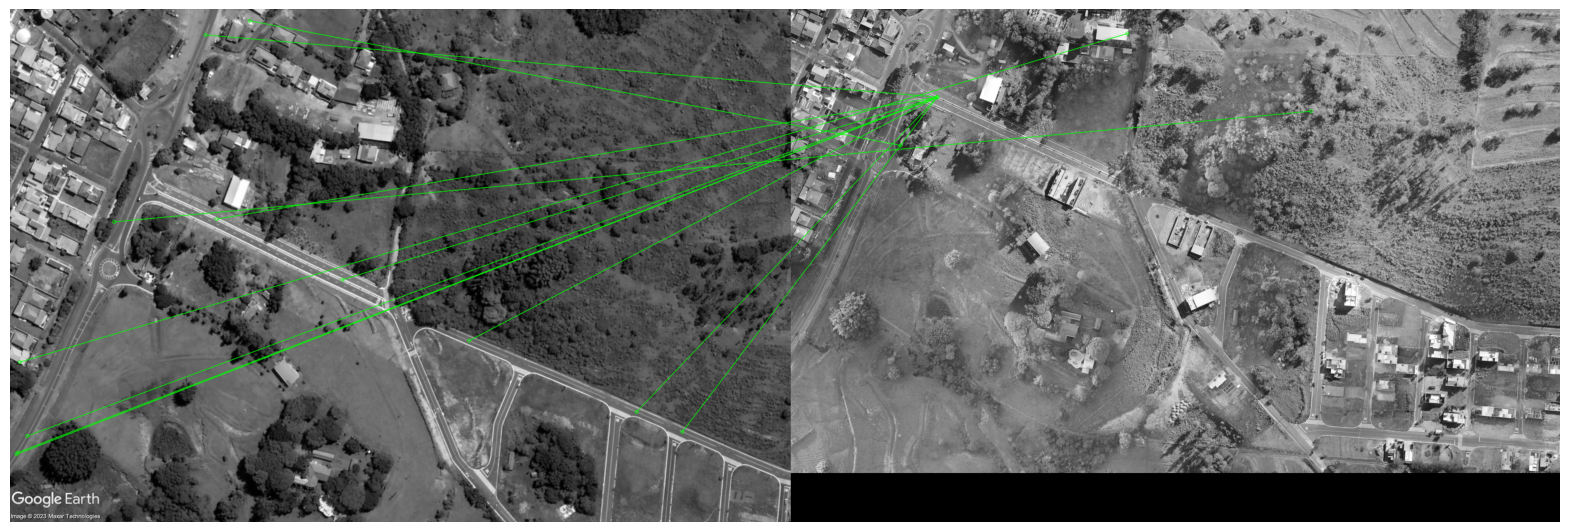

In [143]:
fig = plt.gcf()
fig.set_size_inches(20,20)
# comando abaixo para desabilitar configuração de gráfico, ai desabilita se não fica mostrando os eixos
plt.axis('off')
plt.imshow(cv2.cvtColor(img_correspondencia, cv2.COLOR_BGR2RGB))
plt.show()